In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import maxentep
import maxent
import numpy as np
import scipy.stats as ss
plt.style.use('seaborn-darkgrid')
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')
import tensorflow as tf
import networkx as nx
from keras.callbacks import ReduceLROnPlateau

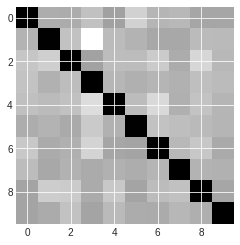

In [2]:
# Make up some population area and mobility network
np.random.seed(0)
M = 10
patches=[f'patch {i}' for i in range(M)]
population = np.round(np.random.normal(loc=500000, scale=300000, size=(M,)))
area = np.maximum(300, np.round(np.random.normal(loc=2000, scale=1000, size=(M,)), 0))
# defining a fully connected mobility matrix
dense_mobility_matrix = np.round(np.abs(np.random.normal(loc=100, scale=50, size=(M,M))))
# setting diagonal values to be dominant
dense_mobility_matrix_diag = np.round(np.abs(np.random.normal(loc=100000, scale=3000, size=(M))))
np.fill_diagonal(dense_mobility_matrix, dense_mobility_matrix_diag)
dense_mobility_matrix_norm = dense_mobility_matrix / np.sum(dense_mobility_matrix, axis=1, keepdims=True)
plt.imshow(np.log(dense_mobility_matrix))
compartments = ['E', 'A', 'I', 'R']
full_compartments = ['S'] + compartments
true_node = 1
infections_compartments = [1,2]
C = len(compartments)

In [3]:
def gen_ref_traj(graph, beta_A = 0.025, beta_I=0.05, alpha =1/3, gamma=1/2, mu=1/7, M=10, C=4, timesteps=100,
                 mobility_matrix=dense_mobility_matrix, population=None, area= None, true_node=None):
    # sparsify mobility matrix for sparse graphs
    sparsed_mobility_matrix = maxentep.sparse_graph_mobility(graph, mobility_matrix)
    tmat = maxentep.TransitionMatrix(compartments, [1,2])
    tmat.add_transition('E', 'A', 1/alpha, 0) # calling this alpha
    tmat.add_transition('E', 'I', 1/gamma, 0) # calling this gamma
    tmat.add_transition('A', 'R',1/mu, 0) # mu
    tmat.add_transition('I', 'R', 1/mu, 0) # mu
    infect_fxn = maxentep.contact_infection_func(infections_compartments, area=area)
    model = maxentep.MetaModel(infect_fxn, timesteps, populations=np.array(population))
    # starting fractions probabilities
    start = np.zeros((M,C)) #anywhere
    # Assume starting from Node true_node
    initial_exposed = 1/population[true_node]
    start[true_node,0] = initial_exposed
    sparsed_mobility_matrix_norm = sparsed_mobility_matrix / np.sum(sparsed_mobility_matrix, axis=1, keepdims=True)
    ref_traj = model(sparsed_mobility_matrix_norm, tmat.value, start, np.array([beta_A,beta_I]))[0]
    ref_traj = ref_traj[tf.newaxis, ...]
    return ref_traj



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



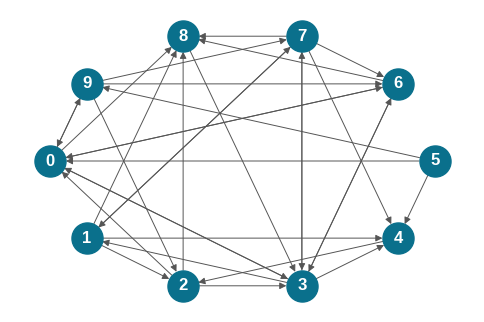

In [17]:
M=10
p = 0.4
graph = maxentep.gen_random_graph(M,p, seed=0)
maxentep.draw_graph(graph, dpi =100)
maxentep.graph_degree(graph)
ref_traj = gen_ref_traj(graph, timesteps=250, population=population,
                          area=area, true_node=true_node)
maxentep.patch_quantile(ref_traj, patch_names = patches, figsize=(10, 6), alpha=0.5, names=['S','E','A','I','R'])
# plt.savefig('p_0.4_graph.png', dpi=600)

In [5]:
def gen_restraints(ref_traj, prior=None, start=None, end=None):
    if prior:
        prior = maxent.Laplace(1)
    else:
        prior = maxent.EmptyPrior()
    restrained_patches = np.random.choice(M, number_of_restrained_patches, replace=False)
    # Visualizing restraints
    restrained_patch = restrained_patches[0]
    restraints, plot_fxns_list = maxentep.compartment_restrainer(restrained_patches, restrained_compartments,
                                                                 ref_traj, prior, npoints = npoints, noise=0.05, start_time=start, end_time=end)
    plt.figure()
    plt.plot(ref_traj[0,:,restrained_patch,:], linestyle='--')
    for i,pf in enumerate(plot_fxns_list[0]):
        pf(plt.gca(), 0)
    plt.title('Observations in the ref traj')
    plt.tight_layout()
    return restraints, plot_fxns_list, restrained_patches

In [27]:
def compare_patches(ref_traj, trajs,weights_dict, method, restrained_patches,plot_fxns_list,
                    *args, figsize=(10, 6), patch_names=None, ** kw_args):
    '''does traj_quantile for trajectories of shape [ntrajs, time, patches, compartments]
    '''
    weights = weights_dict[method]
    NP = trajs.shape[2]
    nrow = int(np.floor(np.sqrt(NP)))
    ncol = int(np.ceil(NP / nrow))
    print(f'Plotting {NP} patches in a {nrow} x {ncol} grid')
    fig, ax = plt.subplots(nrow, ncol, sharex=True,
                           sharey=True, figsize=figsize)
    if method =='unbiased':
        fig.suptitle('{}'.format(method), fontsize=30,y=1.03)
    else:
        fig.suptitle('{} (Patches restrained: {}, Points restrained in each patch: {}, Compartments restrained: {})'
                     .format(method,len(restrained_patches),npoints*number_of_restrained_compartments,restrained_compartments_names)
                     , fontsize=26,y=1.03)
    for i in range(nrow):
        for j in range(ncol):
            if i * ncol + j == NP:
                break
#             traj_quantile(trajs[:,:,i * ncol + j,:], weights=weights, names=full_compartments, ax=axs[0,i])
            ax[i,j].plot(ref_traj[0,:,i * ncol + j,:], linestyle='--')
            if method == 'unbiased':
                maxentep.traj_quantile(trajs[:, :, i * ncol + j, :], *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'biased':
                maxentep.traj_quantile(trajs[:, :, i * ncol + j, :],weights= weights, *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'hyper-biased':
                maxentep.traj_quantile(hme_model.trajs[:, :, i * ncol + j, :],weights= weights, *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'regression':
                ax[i,j].plot(rtraj[p,:,i * ncol + j,:])
#             ax[i, j].set_ylim(0, 1)
            if i * ncol + j in restrained_patches and method != 'unbiased':
                for _,pf in enumerate(plot_fxns_list[restrained_patches.tolist().index(i * ncol + j)]):
                    pf(ax[i,j],0, color='C3')
                ax[i,j].spines['bottom'].set_color('y')
                ax[i,j].spines['top'].set_color('y') 
                ax[i,j].spines['right'].set_color('y')
                ax[i,j].spines['left'].set_color('y')
                ax[i,j].spines['left'].set_linewidth(2)
                ax[i,j].spines['top'].set_linewidth(2)
                ax[i,j].spines['right'].set_linewidth(2)
                ax[i,j].spines['bottom'].set_linewidth(2)
#             plt.tight_layout()
            if patch_names is None:
                ax[i, j].text(trajs.shape[1] // 2, 0.8,
                              f'Patch {i * ncol + j}')
            else:
                patch_names = patch_names
                ax[i, j].set_title(patch_names[i * ncol + j])

            if j == 0 and i == nrow // 2:
                ax[i, j].set_ylabel('Fraction')
            if i == nrow - 1 and j == ncol // 2:
                ax[i, j].set_xlabel('Time')
            if j >= NP % ncol:
                ax[nrow-1, j].set_visible(False)
            if i==2:
                ax[i,j].set_xlabel('Time (days)')
    plt.tight_layout()

def compare_to_ref(ref_traj, trajs, weights, *args, method = None, figsize=(18, 18), patch_names=None, ** kw_args):
    '''does traj_quantile for trajectories of shape [ntrajs, time, patches, compartments] and compares to a ref_traj
    '''
    #     weights = weights_dict[method]
    NP = trajs.shape[2]
    nrow = int(np.floor(np.sqrt(NP)))
    ncol = int(np.ceil(NP / nrow))
    print(f'Plotting {NP} patches in a {nrow} x {ncol} grid')
    fig, ax = plt.subplots(nrow, ncol, sharex=True,
                           sharey=True, figsize=figsize)
    if method =='unbiased':
        fig.suptitle('{}'.format(method), fontsize=30,y=1.06)
    else:
        fig.suptitle('{} (Patches restrained: {}, Points restrained in each patch: {}, Compartments restrained: {})'
                     .format(method,len(restrained_patches),npoints*number_of_restrained_compartments,restrained_compartments_names)
                     , fontsize=26,y=1.002)
    for i in range(nrow):
        for j in range(ncol):
            if i * ncol + j == NP:
                break
    #             traj_quantile(trajs[:,:,i * ncol + j,:], weights=weights, names=full_compartments, ax=axs[0,i])
            ax[i,j].plot(ref_traj[0,:,i * ncol + j,:], linestyle='--')
            if method == 'unbiased':
                maxentep.traj_quantile(trajs[:, :, i * ncol + j, :], *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'biased':
                maxentep.traj_quantile(trajs[:, :, i * ncol + j, :],weights= weights, *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'hyper-biased':
                maxentep.traj_quantile(hme_model.trajs[:, :, i * ncol + j, :],weights= weights, *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'regression':
                ax[i,j].plot(rtraj[p,:,i * ncol + j,:])
            if patch_names is None:
                ax[i, j].text(trajs.shape[1] // 2, 0.8,
                              f'Patch {i * ncol + j}')
            else:
                patch_names = patch_names
                ax[i, j].set_title(patch_names[i * ncol + j])

            if j == 0 and i == nrow // 2:
                ax[i, j].set_ylabel('Fraction')
            if i == nrow - 1 and j == ncol // 2:
                ax[i, j].set_xlabel('Time')
            if j >= NP % ncol:
                ax[nrow-1, j].set_visible(False)
            if i==2:
                ax[i,j].set_xlabel('Time (days)')
    plt.tight_layout()

In [8]:
def gen_samples(graph, mobility_matrix=dense_mobility_matrix, timesteps =250, area = area, populations = population):
    # sparsify mobility matrix for sparse graphs
    sparsed_mobility_matrix = maxentep.sparse_graph_mobility(graph, mobility_matrix)
    tmat = maxentep.TransitionMatrix(compartments, infections_compartments)
    tmat.add_transition('E', 'A', 2, 2) # call this alpha
    tmat.add_transition('E', 'I', 2, 2) # call this gamma
    tmat.add_transition('A', 'R',6, 2) # mu
    tmat.add_transition('I', 'R', 6, 2)
    hyper_pram = maxentep.ParameterHypers()
    hyper_pram.beta_low = [0.005]*2
    hyper_pram.beta_high = [0.08]*2
    hyper_pram.beta_var = [0.1]*2
    hyper_pram.start_high = 2e-5
    hyper_pram.start_var = 0.5
    hyper_pram.R_var = 100
    hyper_pram.beta_start = 0.005
    hyper_pram.start_mean = 8e-6
    hyper_pram.start_scale = 1e-7
    start_logits = np.zeros((M))
    param_model = maxentep.MetaParameterJoint(start_logits, sparsed_mobility_matrix , tmat, name='unbiased_model',
                                              hypers = hyper_pram, n_infectious_compartments=2)
    import tqdm
    N = 512
    batches = 16
    total_batches = N * batches
    outs = []
    infect = maxentep.contact_infection_func(infections_compartments, area = area)
    model = maxentep.MetaModel(infect, timesteps, populations = population)
    prior_prams = []
    for b in tqdm.tqdm(range(batches)):
        ps = param_model.sample(N)
        prior_prams.append(ps)
        outs.append(model(*ps))
    trajs = np.concatenate(outs, axis=0)
    return trajs
trajs = gen_samples(graph, timesteps =250, area = area, populations = population)

Plotting 10 patches in a 3 x 4 grid


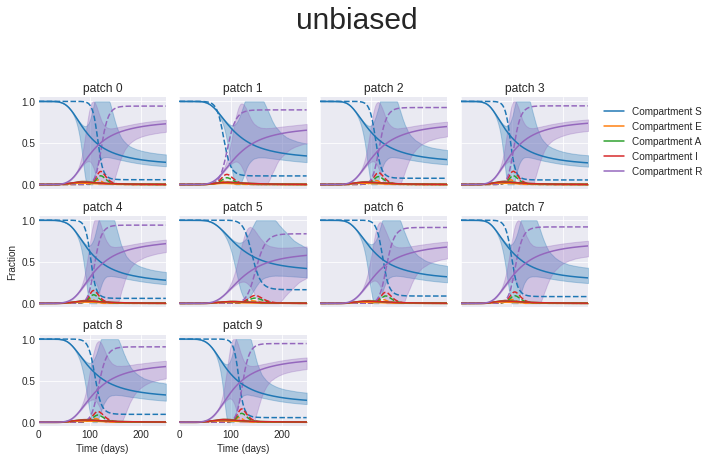

In [19]:
compare_to_ref(ref_traj, trajs, weights=None, method='unbiased', patch_names = patches,
               figsize=(10, 6), alpha=0.3, names=full_compartments)
plt.savefig('p_0.4_sample_traj.png', dpi=600)

Restraints are set in this time range: [50, 140]
115 0.12495463 0.12518725548223025
94 0.018101484 0.019280569271552882
80 0.0020643226 0.0020901163443070568
66 0.00020585931 0.00019921141506698556
129 0.06968553 0.07132731090356506
59 8.0972866e-05 7.936108803514211e-05
94 0.025971796 0.025197429024823748
66 0.00026646306 0.0002657626971055206
122 0.5684295 0.5133975986998592
52 2.4147283e-05 2.437520710921492e-05
136 0.011668986 0.010514136201833404
108 0.12939529 0.13227681917209072
129 0.024679562 0.024438525047154398
101 0.12197824 0.12074188823076225
122 0.049851775 0.05039862048101061
59 0.00034798394 0.00033005998279118253
52 0.000100672 0.00010414426627578579
122 0.79896814 0.8509748191005034
87 0.040125556 0.03886543815367363
108 0.4881514 0.47641069818480947
136 0.06088034 0.06163723486635438
52 9.222261e-08 8.87424532483461e-08
108 0.0027116963 0.002942113403670405
59 3.6464965e-07 3.574889055029746e-07
80 2.0437034e-05 1.9555691368607826e-05
94 0.0003224204 0.0003398707066

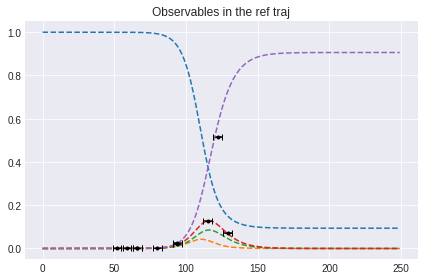

In [32]:
npoints = 5
number_of_restrained_patches = 5
restrained_compartments = [3,4] #(infected patch and recovered)
number_of_restrained_compartments = len(restrained_compartments) 
restrained_compartments_names = [full_compartments[m] for m in restrained_compartments]
restrained_compartments_names = " ".join(restrained_compartments_names)
restraints, plot_fxns_list, restrained_patches = gen_restraints(ref_traj, prior=True, start=50, end=140)

<AxesSubplot:ylabel='Count'>

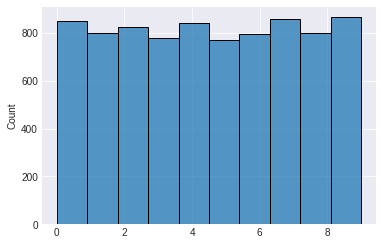

In [33]:
prior_exposed_patch = maxentep.exposed_finder(trajs)
sns.histplot(x=prior_exposed_patch, label='Prior',
            color='C0',bins=M)

In [34]:
def maxent_fit(trajs, restraints):
    me_model = maxent.MaxentModel(restraints)
    from tensorflow import keras
    optimizer=keras.optimizers.Adam(lr=1e-2) 
    me_model.compile(optimizer=optimizer, loss='mean_squared_error')
    reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.9,
                              patience=10, min_lr=0)
    me_history = me_model.fit(trajs, batch_size=trajs.shape[0], epochs=200, callbacks=[reduce_lr])
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
    ax[0].plot(me_history.history['loss'])
    ax[0].set_yscale('log')
    ax[0].set_title('loss')
#     ax[1].show()
    ax[1].plot(me_history.history['weight-entropy'])
    ax[1].set_title('weight-entropy')
    return me_model

Epoch 1/200
1/1 [==============================] - 0s 1ms/step - loss: 53.7612 - weight-entropy: 1.2431
Epoch 2/200
1/1 [==============================] - 0s 1ms/step - loss: 51.2479 - weight-entropy: 1.5927
Epoch 3/200
1/1 [==============================] - 0s 855us/step - loss: 41.3576 - weight-entropy: 2.5652
Epoch 4/200
1/1 [==============================] - 0s 852us/step - loss: 20.2015 - weight-entropy: 4.3329
Epoch 5/200
1/1 [==============================] - 0s 674us/step - loss: 9.0972 - weight-entropy: 5.3321
Epoch 6/200
1/1 [==============================] - 0s 922us/step - loss: 8.9329 - weight-entropy: 5.2825
Epoch 7/200
1/1 [==============================] - 0s 909us/step - loss: 9.7450 - weight-entropy: 5.1443
Epoch 8/200
1/1 [==============================] - 0s 659us/step - loss: 10.3639 - weight-entropy: 5.0441
Epoch 9/200
1/1 [==============================] - 0s 653us/step - loss: 10.6478 - weight-entropy: 4.9821
Epoch 10/200
1/1 [==============================] - 0

1/1 [==============================] - 0s 938us/step - loss: 1.4184 - weight-entropy: 3.9298
Epoch 79/200
1/1 [==============================] - 0s 663us/step - loss: 1.3965 - weight-entropy: 3.9411
Epoch 80/200
1/1 [==============================] - 0s 651us/step - loss: 1.3756 - weight-entropy: 3.9527
Epoch 81/200
1/1 [==============================] - 0s 652us/step - loss: 1.3558 - weight-entropy: 3.9644
Epoch 82/200
1/1 [==============================] - 0s 873us/step - loss: 1.3369 - weight-entropy: 3.9763
Epoch 83/200
1/1 [==============================] - 0s 674us/step - loss: 1.3191 - weight-entropy: 3.9884
Epoch 84/200
1/1 [==============================] - 0s 700us/step - loss: 1.3022 - weight-entropy: 4.0006
Epoch 85/200
1/1 [==============================] - 0s 717us/step - loss: 1.2862 - weight-entropy: 4.0129
Epoch 86/200
1/1 [==============================] - 0s 721us/step - loss: 1.2711 - weight-entropy: 4.0253
Epoch 87/200
1/1 [==============================] - 0s 684u

Epoch 155/200
1/1 [==============================] - 0s 887us/step - loss: 0.9085 - weight-entropy: 4.5810
Epoch 156/200
1/1 [==============================] - 0s 838us/step - loss: 0.9058 - weight-entropy: 4.5858
Epoch 157/200
1/1 [==============================] - 0s 1ms/step - loss: 0.9030 - weight-entropy: 4.5906
Epoch 158/200
1/1 [==============================] - 0s 851us/step - loss: 0.9003 - weight-entropy: 4.5954
Epoch 159/200
1/1 [==============================] - 0s 980us/step - loss: 0.8976 - weight-entropy: 4.6002
Epoch 160/200
1/1 [==============================] - 0s 914us/step - loss: 0.8950 - weight-entropy: 4.6050
Epoch 161/200
1/1 [==============================] - 0s 1ms/step - loss: 0.8923 - weight-entropy: 4.6097
Epoch 162/200
1/1 [==============================] - 0s 871us/step - loss: 0.8897 - weight-entropy: 4.6145
Epoch 163/200
1/1 [==============================] - 0s 711us/step - loss: 0.8871 - weight-entropy: 4.6192
Epoch 164/200
1/1 [======================

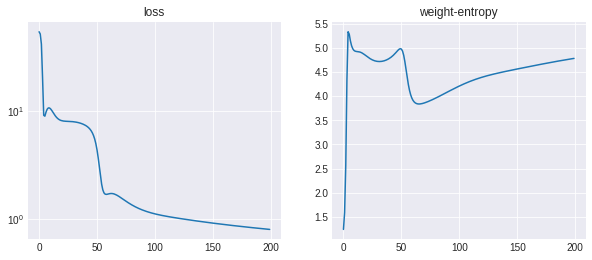

In [35]:
me_model = maxent_fit(trajs, restraints)

Plotting 10 patches in a 3 x 4 grid


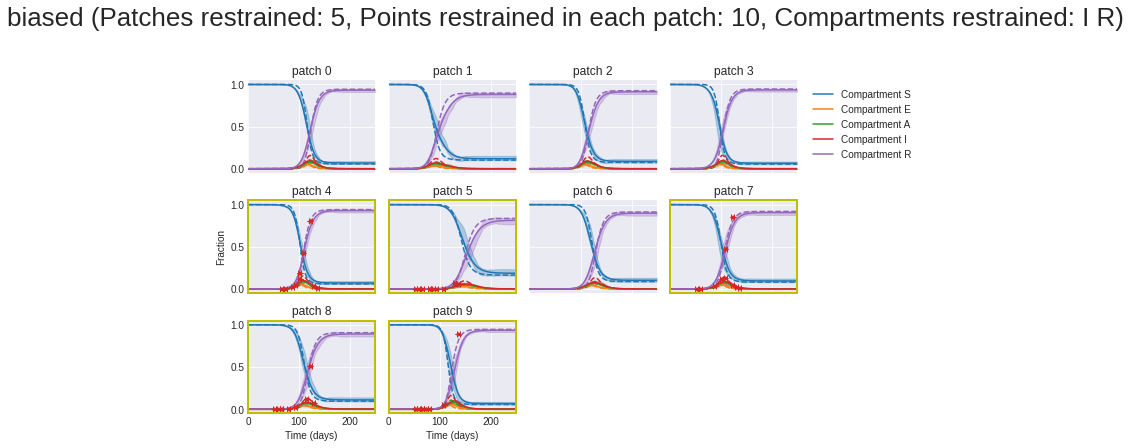

In [36]:
weights_dict = {'unbiased':None, 'biased':me_model.traj_weights}
compare_patches(ref_traj, trajs, weights_dict,'biased', restrained_patches, plot_fxns_list,
                patch_names = patches, figsize=(10, 6), alpha=0.3, names=full_compartments)
plt.savefig('p_0.4_posterior.png', dpi=600)

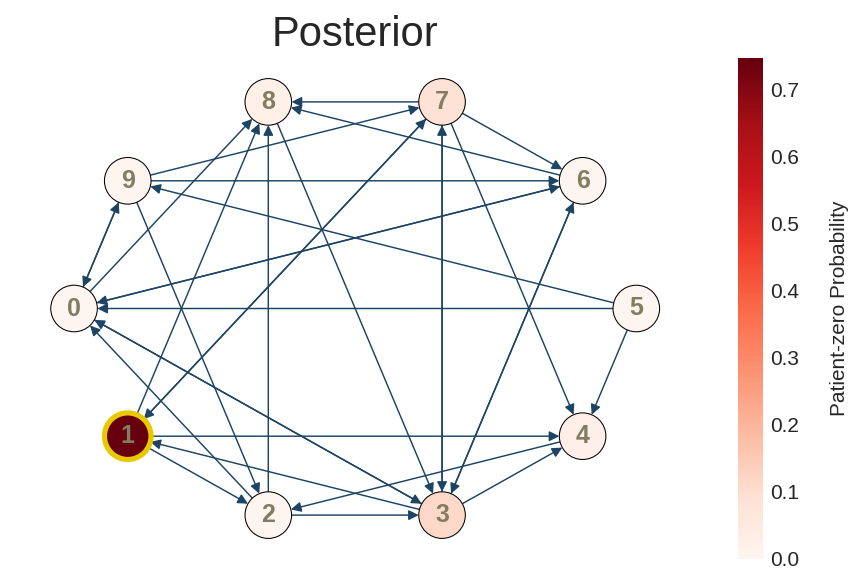

In [37]:
me_w = me_model.traj_weights
exposed_prob = maxentep.weighted_exposed_prob_finder(
                            prior_exposed_patch, M)
weighted_exposed_prob = maxentep.weighted_exposed_prob_finder(
                            prior_exposed_patch, M, weights=me_w)
# maxentep.draw_graph(graph, weights=exposed_prob, title='Prior', heatmap=True, true_origin=true_node)
# fig, ax = plt.subplots()
maxentep.draw_graph(graph, weights=weighted_exposed_prob, title='Posterior', heatmap=True, true_origin=true_node)
plt.tight_layout()
plt.savefig('p_0.4_p0_posterior.png', dpi=600)

In [38]:
traj_loss = maxentep.traj_loss(ref_traj, trajs, me_w)
p0_loss = maxentep.p0_loss(trajs,me_w, true_node)
# posterior_exposed_prob = maxentep.weighted_exposed_prob_finder(prior_exposed_patch, M, weights = me_w)
print(f'P0 cross-entropy : {p0_loss:.3f}, Traj KL : {traj_loss:.3f}')
print('Top 5 posterior probabilities for P0: \n', sorted(zip(weighted_exposed_prob, patches), reverse=True)[:5])

P0 cross-entropy : 0.293, Traj KL : 0.008
Top 5 posterior probabilities for P0: 
 [(0.7462977859454332, 'patch 1'), (0.11079493907516205, 'patch 3'), (0.08740925199063979, 'patch 7'), (0.02722693982284188, 'patch 4'), (0.025831606358674437, 'patch 8')]


In [16]:
n_samples = 1000
connecting_probability = np.linspace(0.25, 1, n_samples)
run_doe = False
dat=[]
if run_doe:
    for i,p in enumerate(connecting_probability):
        M=10
        true_node = np.random.randint(M)
        graph = maxentep.gen_random_graph(M,p)
        ref_traj = gen_ref_traj(graph, timesteps=250, population=population,
                                  area=area, true_node=true_node)
        trajs = gen_samples(graph, timesteps =250, area = area, populations = population)
        npoints = 5
        number_of_restrained_patches = 5
        restrained_compartments = [3,4] #(infected patch and recovered)
        number_of_restrained_compartments = len(restrained_compartments) 
        restrained_compartments_names = [full_compartments[m] for m in restrained_compartments]
        restrained_compartments_names = " ".join(restrained_compartments_names)
    #     plt.figure()
        restraints, plot_fxns_list, restrained_patches = gen_restraints(ref_traj, prior=True, start=50, end=140)
        prior_exposed_patch = maxentep.exposed_finder(trajs)
        me_model = maxent_fit(trajs, restraints)
        weights_dict = {'unbiased':None, 'biased':me_model.traj_weights}
        me_w = me_model.traj_weights
        exposed_prob = maxentep.weighted_exposed_prob_finder(
                                    prior_exposed_patch, M)
        weighted_exposed_prob = maxentep.weighted_exposed_prob_finder(
                                    prior_exposed_patch, M, weights=me_w)
        traj_loss = maxentep.traj_loss(ref_traj, trajs, me_w).numpy()
        p0_loss = maxentep.p0_loss(trajs,me_w, true_node)
        compare_patches(ref_traj, trajs, weights_dict,'biased', restrained_patches, plot_fxns_list,
                    patch_names = patches, figsize=(15, 10), alpha=0.3, names=full_compartments)
        fig, ax = plt.subplots()
        maxentep.draw_graph(graph, weights=weighted_exposed_prob, title=f'Posterior - P = {p:.3f}', heatmap=True, true_origin=true_node)
        print(f'P0 cross-entropy : {p0_loss:.3f}, Traj KL : {traj_loss:.3f}')
        print(f'Iteration: {i}, p: {p}, True_node: {true_node}'
              '\nTop 5 posterior probabilities for P0: \n', sorted(zip(weighted_exposed_prob, patches), reverse=True)[:5])
        p0_pred = sorted(zip(weighted_exposed_prob, patches), reverse=True)[:1][0]
        certainty = p0_pred[0]
        predcited_node = int(p0_pred[1].split()[1])
        if predcited_node == true_node:
            prediction = True
        else:
            prediction = False
        dat.append([traj_loss, p0_loss, certainty, prediction, true_node, predcited_node])
    with open('data.npz', 'wb') as f:
        np.save(f, dat)
else:
    results = np.load('../examples/data.npz')
    for f in results.files:
        dat.append(results[f].astype(float))
dat = np.array(dat)

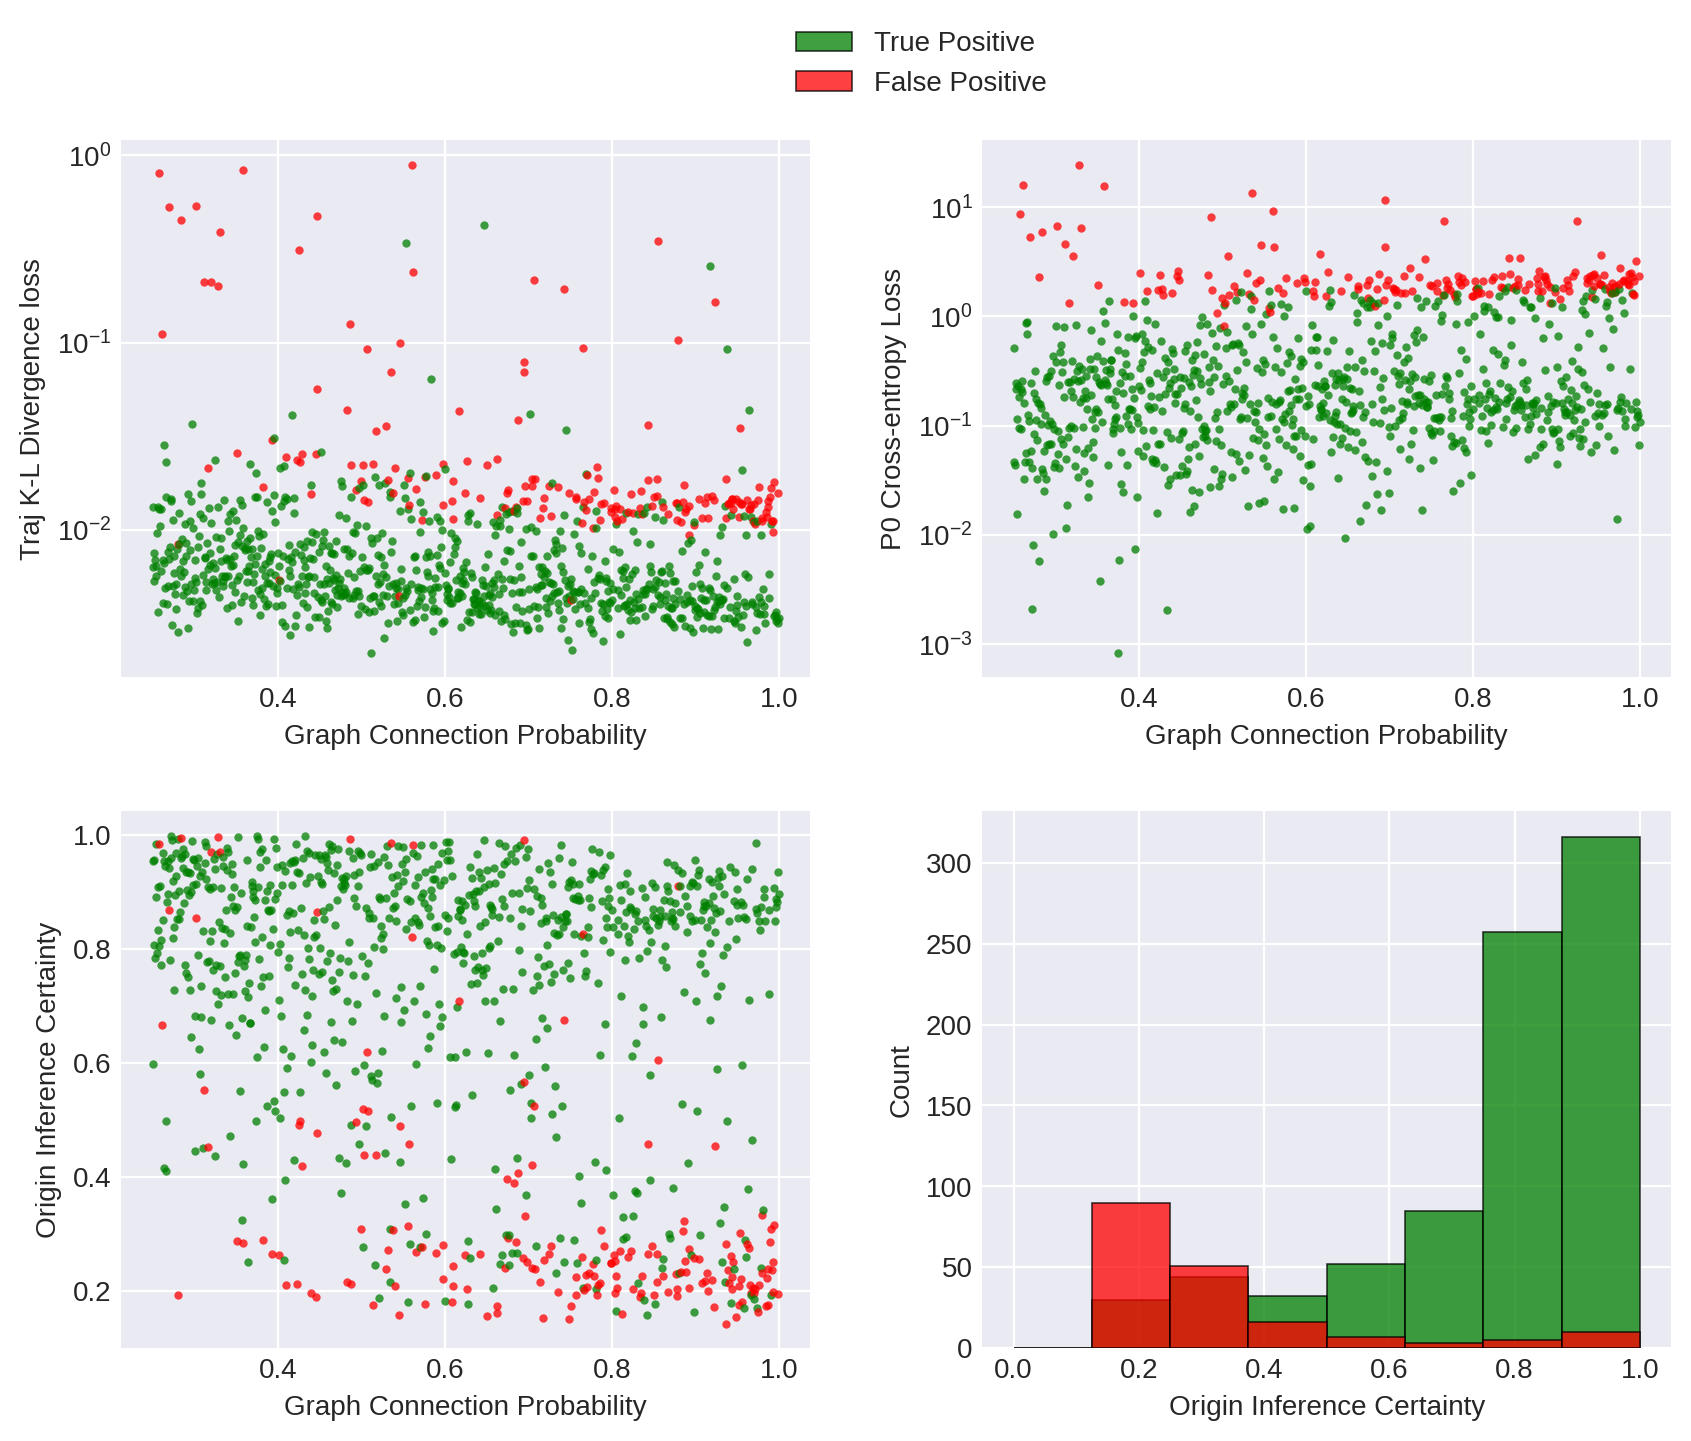

In [17]:
marker_colors = []
predictions = dat[:,3].astype(bool)
certainties = dat[:,2]
cross_entropy = dat[:,1]
K_L = dat[:,0]
true_nodes = dat[:,4]
predicted_nodes = dat[:,5]
alpha = 0.75
# K_L, cross_entropy, certainties, predictions, true_nodes, predicted_nodes = np.array(dat, dtype=object)
for i in range(len(connecting_probability)):
    if predictions[i]:
        marker_colors.append('g')
    else:
        marker_colors.append('r')
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,8), dpi=200)
ax[0,0].set_xlabel('Graph Connection Probability')
ax[0,0].set_ylabel('Traj K-L Divergence loss')
ax[0,0].set_yscale('log')
ax[0,1].set_xlabel('Graph Connection Probability')
ax[0,1].set_ylabel('P0 Cross-entropy Loss')
ax[0,1].set_yscale('log')
ax[1,0].set_xlabel('Graph Connection Probability')
ax[1,0].set_ylabel('Origin Inference Certainty')
fps = []
tps = []
for i, mc in enumerate(marker_colors):
    ax[0,0].plot(connecting_probability[i], K_L[i], marker='.', markerfacecolor=mc,
               markeredgecolor='None', label=f'{bool(predictions[i])} Positive', alpha=alpha)
    ax[0,1].plot(connecting_probability[i], cross_entropy[i], marker='.', markerfacecolor=mc,
               markeredgecolor='None', label=f'{bool(predictions[i])} Positive', alpha=alpha)
    ax[1,0].plot(connecting_probability[i], certainties[i], marker='.', markerfacecolor=mc,
               markeredgecolor='None', label=f'{bool(predictions[i])} Positive', alpha=alpha)
    if bool(predictions[i]):
        tps.append(certainties[i])
    else:
        fps.append(certainties[i])
bins = np.linspace(0, 1, 9)
counts_t, bins_t, bars_t = ax[1,1].hist(tps, bins, alpha=alpha, label='True Positive', color='g', rwidth=1, edgecolor='k', linewidth=0.6)
counts_f, bins_f, bars_f = ax[1,1].hist(fps, bins, alpha=alpha, label='False Positive', color='r', rwidth=1, edgecolor='k', linewidth=0.6)
ax[1,1].set_xlabel('Origin Inference Certainty')
ax[1,1].set_ylabel('Count')
fig.subplots_adjust(hspace=0.25, wspace=0.25)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax[0,0].legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.38, 1.25))
bins_t = bins_t[1:]

Text(0, 0.5, 'Accuracy')

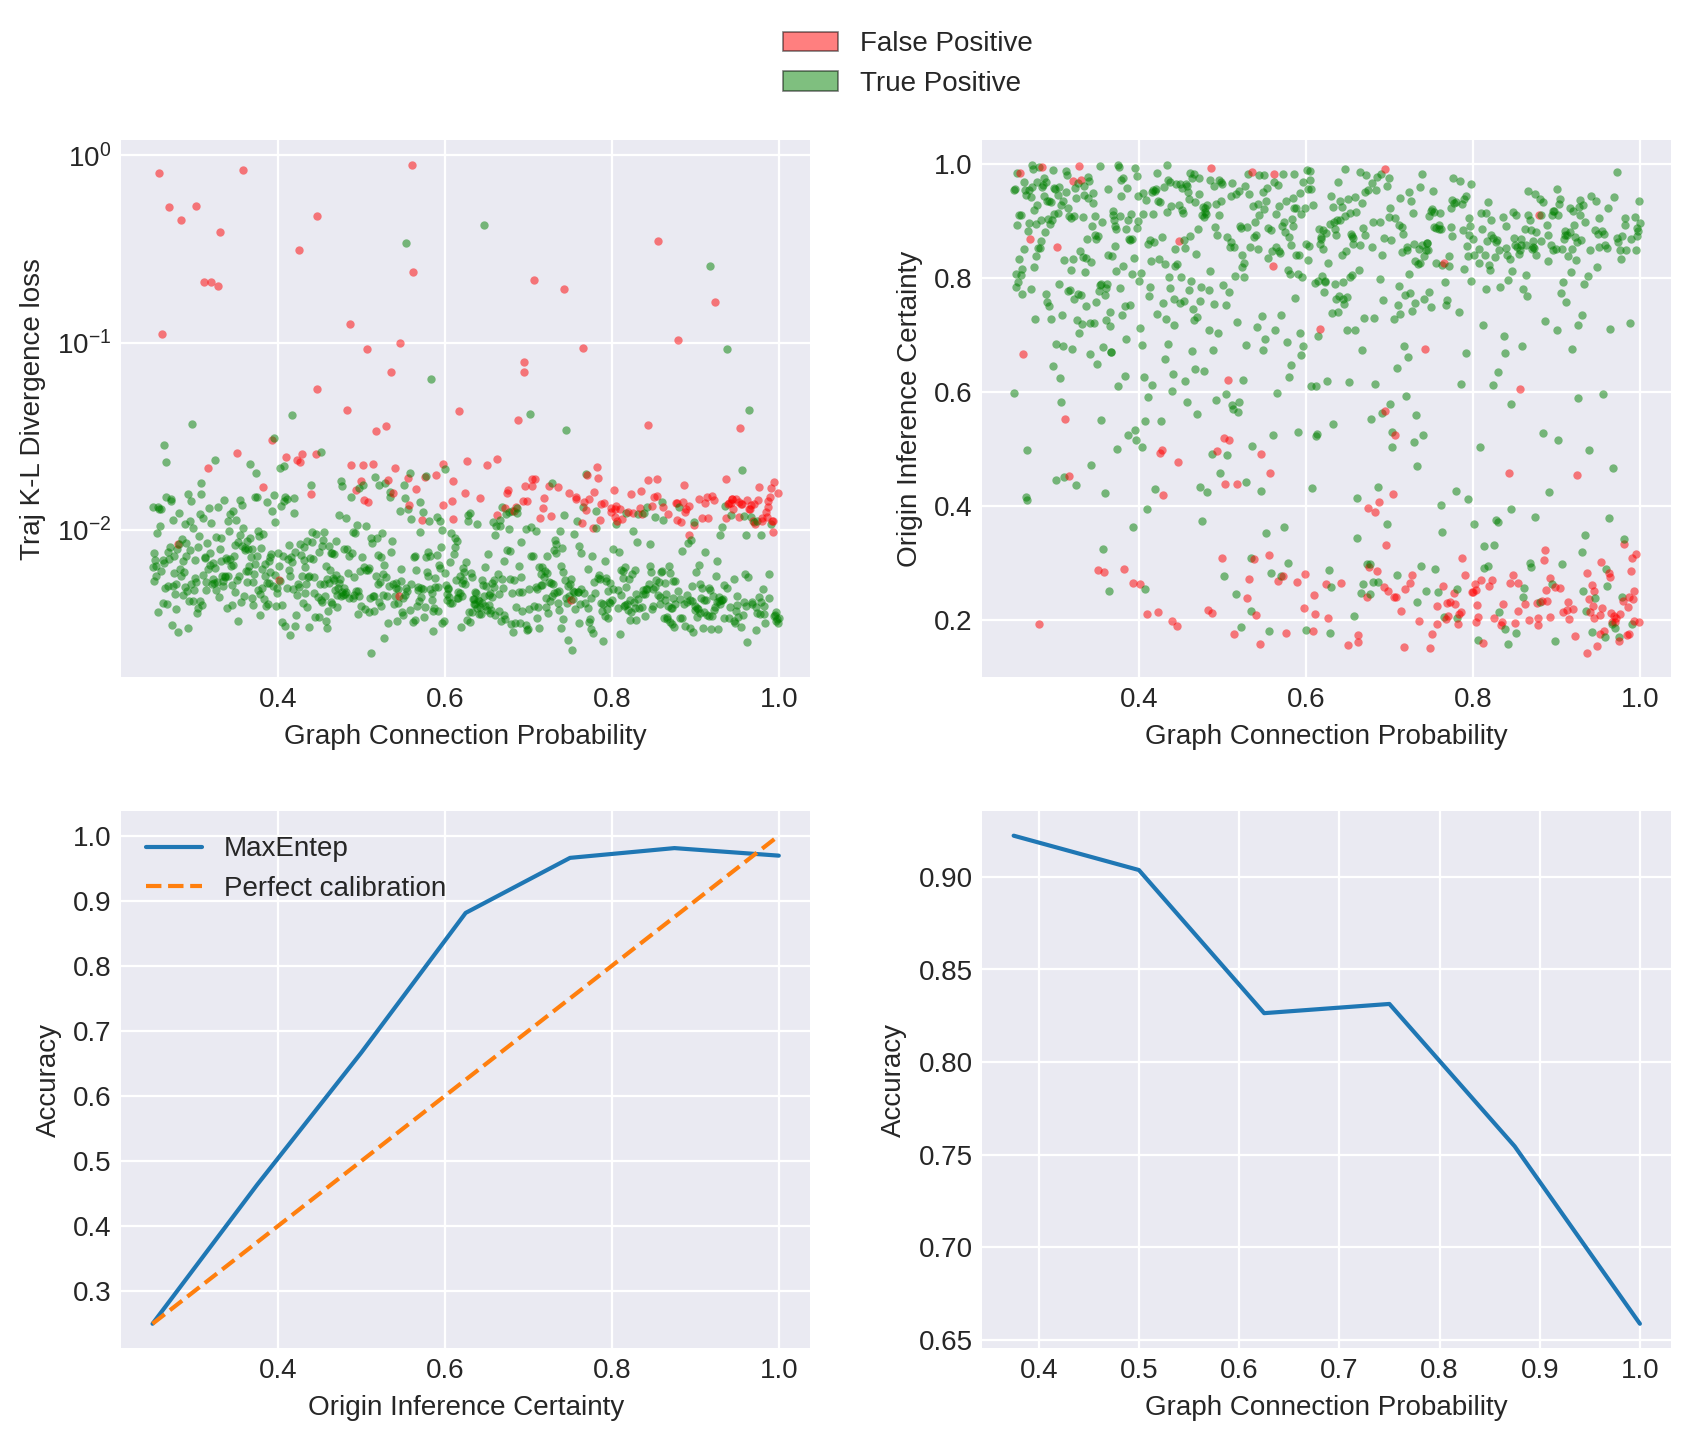

In [20]:
marker_colors = []
predictions = dat[:,3].astype(bool)
certainties = dat[:,2]
cross_entropy = dat[:,1]
K_L = dat[:,0]
true_nodes = dat[:,4]
predicted_nodes = dat[:,5]
alpha = 0.5
# K_L, cross_entropy, certainties, predictions, true_nodes, predicted_nodes = np.array(dat, dtype=object)
for i in range(len(connecting_probability)):
    if predictions[i]:
        marker_colors.append('g')
    else:
        marker_colors.append('r')
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,8), dpi=200)
ax[0,0].set_xlabel('Graph Connection Probability')
ax[0,0].set_ylabel('Traj K-L Divergence loss')
ax[0,0].set_yscale('log')
ax[0,1].set_xlabel('Graph Connection Probability')
ax[0,1].set_ylabel('Origin Inference Certainty')
fps = []
tps = []
fps_p_node = []
tps_p_node = []
for i, mc in enumerate(marker_colors):
    ax[0,0].plot(connecting_probability[i], K_L[i], marker='.', markerfacecolor=mc,
               markeredgecolor='None', label=f'{bool(predictions[i])} Positive', alpha=alpha)
    ax[0,1].plot(connecting_probability[i], certainties[i], marker='.', markerfacecolor=mc,
               markeredgecolor='None', label=f'{bool(predictions[i])} Positive', alpha=alpha)
    if bool(predictions[i]):
        tps.append(certainties[i])
        tps_p_node.append(connecting_probability[i])
    else:
        fps.append(certainties[i])
        fps_p_node.append(connecting_probability[i])
bins = np.linspace(0, 1, 9)
counts_t, bins_t, bars_t = ax[1,0].hist(tps, bins, alpha=alpha, label='True Positive', color='g', rwidth=1, edgecolor='k', linewidth=0.6)
counts_f, bins_f, bars_f = ax[1,0].hist(fps, bins, alpha=alpha, label='False Positive', color='r', rwidth=1, edgecolor='k', linewidth=0.6)
fig.subplots_adjust(hspace=0.25, wspace=0.25)


bins_t = bins_t[1:]
accuracy = counts_t/(counts_f + counts_t)
# plt.figure(dpi=150)
ax[1,0].clear()
ax[1,0].plot(bins_t, accuracy, label='MaxEntep')
non_nan = np.min(np.where(np.isfinite(accuracy)))
ax[1,0].plot([bins_t[non_nan],1],[bins_t[non_nan],1], '--', label='Perfect calibration')
ax[1,0].set_xlabel('Origin Inference Certainty')
ax[1,0].set_ylabel('Accuracy')
legend = ax[1,0].legend()
bins_p_node = np.unique(connecting_probability)
counts_f_p_node, bins_f_p_node, bars_f_p_node = ax[1,1].hist(fps_p_node, bins, alpha=alpha, label='False Positive', color='r', rwidth=1, edgecolor='k', linewidth=0.6)
counts_t_p_node, bins_t_p_node, bars_t_p_node = ax[1,1].hist(tps_p_node, bins, alpha=alpha, label='True Positive', color='g', rwidth=1, edgecolor='k', linewidth=0.6)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax[0,0].legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.36, 1.25))
ax[1,1].clear()
accuracy_p_node = counts_t_p_node/(counts_f_p_node + counts_t_p_node)
non_nan_p_node = np.min(np.where(np.isfinite(accuracy_p_node)))
ax[1,1].plot(bins_t,accuracy_p_node, label='Maxent')
ax[1,1].set_xlabel('Graph Connection Probability')
ax[1,1].set_ylabel('Accuracy')


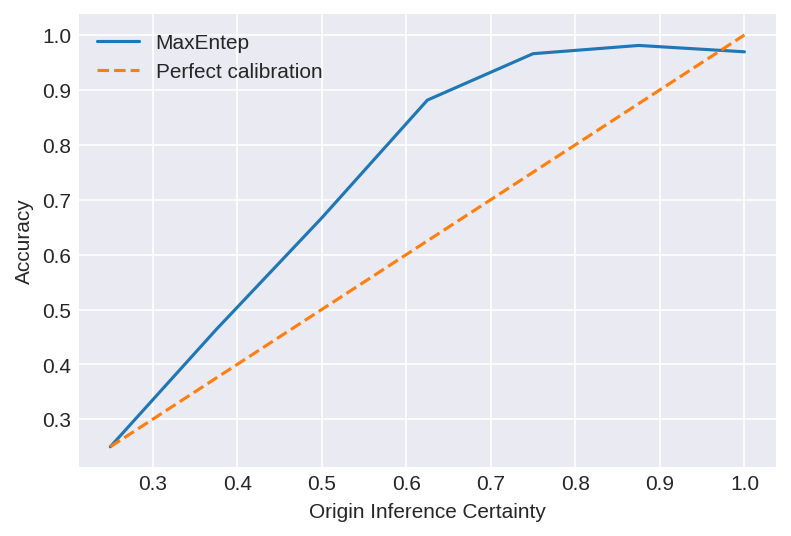

In [19]:
accuracy = counts_t/(counts_f + counts_t)
plt.figure(dpi=150)
plt.plot(bins_t, accuracy, label='MaxEntep')
non_nan = np.min(np.where(np.isfinite(accuracy)))
plt.plot([bins_t[non_nan],1],[bins_t[non_nan],1], '--', label='Perfect calibration')
plt.xlabel('Origin Inference Certainty')
plt.ylabel('Accuracy')
legend = plt.legend()

## Finding [Time Horizon](https://arxiv.org/abs/2006.11913)

$ t_{max} \sim \frac{log(S_0)}{\mu (R_0 -1)}$

In [7]:
def density_fxn(n, area=area, xi=0.005):
        return 2. - tf.math.exp(-xi * n / area)
sparsed_mobility_matrix = maxentep.sparse_graph_mobility(graph, dense_mobility_matrix)
sparsed_mobility_matrix_norm = sparsed_mobility_matrix / np.sum(sparsed_mobility_matrix, axis=1, keepdims=True)
# finding effective population
effective_population = np.array(population)[np.newaxis, :] @  sparsed_mobility_matrix_norm
ntot = np.sum(effective_population, axis=1)
# k is the avergae number of contacts across the whole population
k = 10.
f = density_fxn(effective_population)
# finding normalization factor
z = ntot * k / np.sum(effective_population * density_fxn(effective_population), axis=1)
print(f'z = {z}')
M =  np.array(population)*np.einsum('il,jl,l->ij', sparsed_mobility_matrix_norm, sparsed_mobility_matrix_norm, np.squeeze(f/effective_population))
def kth_term(matrix, k):
        # This function outputs the spectral radius of the input matrix (k-> inf)
        # using Gelfand's formula
        matrix = np.linalg.matrix_power(matrix, k)
        f_norm = np.linalg.norm(matrix, 'fro')
        a = f_norm**(1.0/k)
        return a
spectral_radius = kth_term(M,75)
print(f'spectral_radius = {spectral_radius}')
mu = 1/7
beta = 0.05
beta_prime = 0.025
epsilon = 0.6
R_0 = z * 1 / mu * (epsilon * beta + (1-epsilon) * beta_prime) * spectral_radius
print(f'R_0 = {R_0}')
t_max = np.log(ntot) / mu / (R_0-1)
print(f't_max = {t_max}')

z = [5.56176962]
spectral_radius = 1.9309664654011192
R_0 = [3.00708538]
t_max = [55.07528889]
